In [126]:
# Modules for debugging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend


# Custom modules
from preprocessing_post_fastsurfer.alignment import *
from preprocessing_post_fastsurfer.cropping import *
from preprocessing_post_fastsurfer.extraction import *
from preprocessing_post_fastsurfer.file_handling import *
from preprocessing_post_fastsurfer.mesh_creation import *
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *

# Custom modules
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.subject_dataset import *

np.set_printoptions(precision=2, suppress=True)

In [127]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the disease labels
labels_string = 'research_group'


In [128]:
dataset = SubjectDataset(data_path, selected_labels)

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/idaSearch_3_19_2025.csv']


In [129]:
print(dataset.subject_list[10].subject_metadata)

       Subject ID Sex  Weight Research Group  APOE A1  APOE A2  \
21139  094_S_1241   M   107.9             CN        3        3   

                Visit Archive Date Study Date   Age  MMSE Total Score  \
21139  ADNI Screening    8/08/2007  2/16/2007  72.2              30.0   

       GDSCALE Total Score  FAQ Total Score  NPI-Q Total Score  \
21139                  0.0              NaN                NaN   

                                             Description       Type  Image ID  
21139  MPR; GradWarp; B1 Correction; N3; Scaled <- MP...  Processed     66069  


In [130]:
labels = np.array([dataset[index]['research_group'] for index in range(len(dataset.subject_list))])

scores = np.array([dataset[index]['scores'] for index in range(len(dataset.subject_list))])

In [131]:
scoring = 'roc_auc'

with parallel_backend('threading', n_jobs=8):

    model = HistGradientBoostingClassifier(learning_rate=0.0001, max_iter=4, max_leaf_nodes=4, l2_regularization=4.0, min_samples_leaf=150, max_depth=2, class_weight='balanced', scoring=scoring)

    # Need to implement k fold with non-leakage datasets, there could be leakage here if single_img_per_subject is not selected
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, scores, labels, cv=cv, scoring=scoring)

    print(f'Cross-validation {scoring} scores: {cv_scores}')
    print(f'Mean cross-validation {scoring}: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation {scoring}: {np.std(cv_scores)}')

Cross-validation roc_auc scores: [0.74 0.79 0.69 0.81 0.71 0.79 0.79 0.76 0.74 0.7 ]
Mean cross-validation roc_auc: 0.7524192835028748
Standard deviation of cross-validation roc_auc: 0.03908948221723258


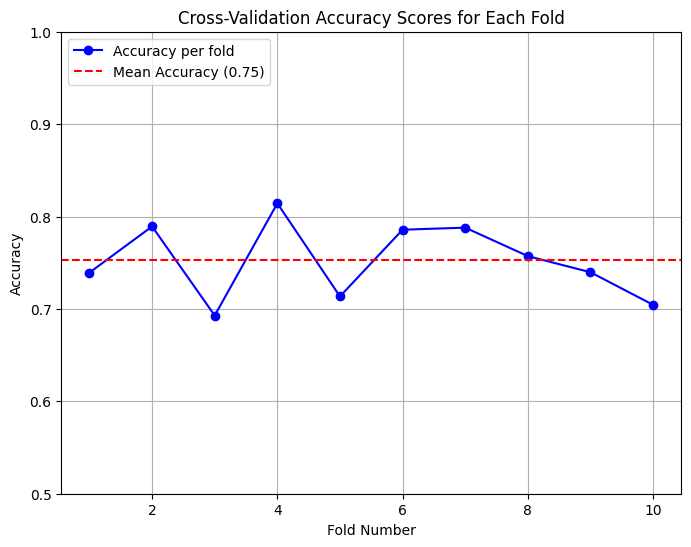

In [132]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label='Accuracy per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy ({np.mean(cv_scores):.2f})')
plt.title('Cross-Validation Accuracy Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [133]:
model = HistGradientBoostingClassifier(learning_rate=0.0001, max_iter=4, max_leaf_nodes=4, l2_regularization=4.0, min_samples_leaf=150, max_depth=2, class_weight='balanced', scoring=scoring)

model.fit(scores, labels)

HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=4.0,
                               learning_rate=0.0001, max_depth=2, max_iter=4,
                               max_leaf_nodes=4, min_samples_leaf=150,
                               scoring='roc_auc')

[[25.  0. nan nan]
 [29.  1. nan nan]
 [29.  1. nan nan]
 ...
 [29.  0. nan nan]
 [29.  2. nan nan]
 [29.  1. nan nan]]
543


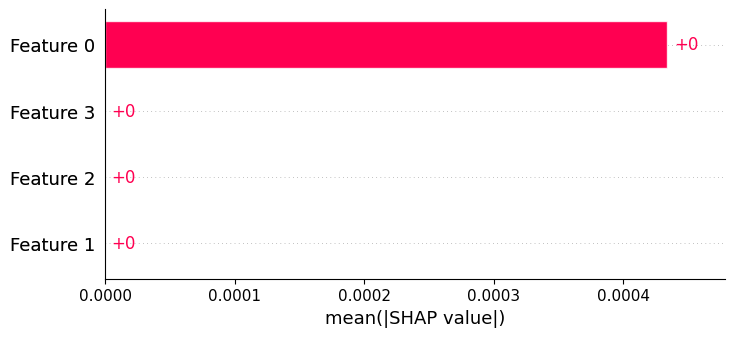

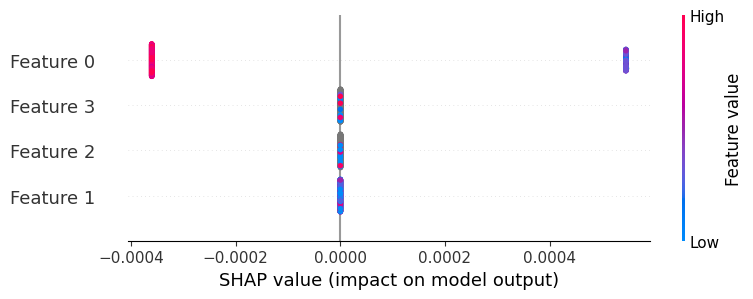

In [161]:
import shap

explainer = shap.Explainer(model)

print(scores)

sample = scores # np.random.choice(scores.shape[0], 1, replace=False)

shap_values = explainer(sample)

print(len(shap_values))

shap.plots.bar(shap_values)

shap.summary_plot(shap_values, scores)